In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("BTFR_i_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

di = df.set_index("PGC")

di.head()

,Vmod,DM_75,DMi_fid,F21,eF21,lgWmxi,elgWi,Qs,i***
PGC,,,,,,,,,
4,4154,33.717026,33.359989,1.905,0.070000,2.189,0.011,5.0,15.12
16,5387,34.281429,34.647761,1.190,0.203539,2.515,0.025,5.0,13.58
55,4507,33.894131,33.644108,4.300,0.317899,2.260,0.025,5.0,15.22
68,7480,34.994202,34.763757,1.610,0.274314,2.390,0.043,5.0,14.52
70,6557,34.708220,35.204753,8.330,0.120000,2.636,0.003,5.0,13.24


In [4]:
df = pd.read_csv("BTFR_W1_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

d1 = df.set_index("PGC")

d1.head()

,Vmod,DM_75,DM1_fid,F21,eF21,lgWmxi,elgWi,Qw,w1***
PGC,,,,,,,,,
2,4786,34.024557,34.533084,4.730,0.805837,2.744,0.029,5.0,11.89
4,4154,33.717026,33.484186,1.905,0.070000,2.189,0.011,4.0,16.07
12,6297,34.620362,35.009558,3.400,0.579492,2.606,0.021,5.0,13.59
16,5387,34.281429,34.701190,1.190,0.203539,2.515,0.025,5.0,13.99
55,4507,33.894131,33.663790,4.300,0.317899,2.260,0.025,4.0,16.20


In [5]:
df = di.join(d1, how='left', lsuffix='_i', rsuffix='_w1')

commons = ['Vmod', 'DM_75', 'F21', 'eF21', 'lgWmxi', 'elgWi']
for col in commons:
    df[col] = df.apply(lambda X: X[col+"_i"] if ~np.isnan(X[col+"_i"]) else X[col+"_w1"], axis=1)

df = df[commons+["DMi_fid", "DM1_fid", "Qs", "Qw", 'w1***', 'i***']]

df.head()

,Vmod,DM_75,F21,eF21,lgWmxi,elgWi,DMi_fid,DM1_fid,Qs,Qw,w1***,i***
PGC,,,,,,,,,,,,
4,4154.0,33.717026,1.905,0.070000,2.189,0.011,33.359989,33.484186,5.0,4.0,16.07,15.12
16,5387.0,34.281429,1.190,0.203539,2.515,0.025,34.647761,34.701190,5.0,5.0,13.99,13.58
55,4507.0,33.894131,4.300,0.317899,2.260,0.025,33.644108,33.663790,5.0,4.0,16.20,15.22
68,7480.0,34.994202,1.610,0.274314,2.390,0.043,34.763757,34.593097,5.0,5.0,15.03,14.52
70,6557.0,34.708220,8.330,0.120000,2.636,0.003,35.204753,35.077088,5.0,5.0,13.54,13.24


In [22]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

cf3.head()

,DM_cf3
PGC,
4,33.52
27,35.89
40,35.34
51,36.91
55,34.34


In [23]:
df34 = df.join(cf3, how='inner')

df34.head()

,Vmod,DM_75,F21,eF21,lgWmxi,elgWi,DMi_fid,DM1_fid,Qs,Qw,w1***,i***,DM_cf3
PGC,,,,,,,,,,,,,
4,4154.0,33.717026,1.905,0.070000,2.189,0.011,33.359989,33.484186,5.0,4.0,16.07,15.12,33.52
55,4507.0,33.894131,4.300,0.317899,2.260,0.025,33.644108,33.663790,5.0,4.0,16.20,15.22,34.34
70,6557.0,34.708220,8.330,0.120000,2.636,0.003,35.204753,35.077088,5.0,5.0,13.54,13.24,35.35
76,6698.0,34.754419,4.425,0.110000,2.624,0.013,34.733544,34.811902,5.0,5.0,13.23,12.91,34.95
124,6083.0,34.545283,4.250,0.100000,2.402,0.010,34.429524,34.503845,5.0,5.0,15.21,14.51,34.56


(<AxesSubplot:label='3a5a7882-07e2-41fc-8a0c-d7ce8ea884cb'>,
 <AxesSubplot:label='60f65c3c-b605-479d-ad59-90ebd9d7b7d0'>)

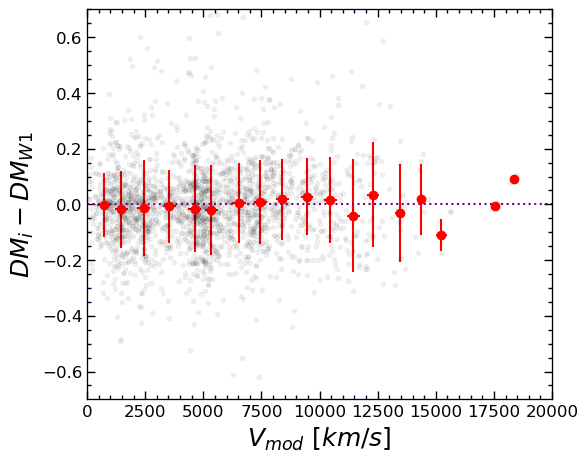

In [6]:
dff = df[(df.Qs>2)&(df.Qw>2)]
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DMi_fid.values-dff.DM1_fid.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")


Text(0.5, 1.0, 'BTFR: i-band')

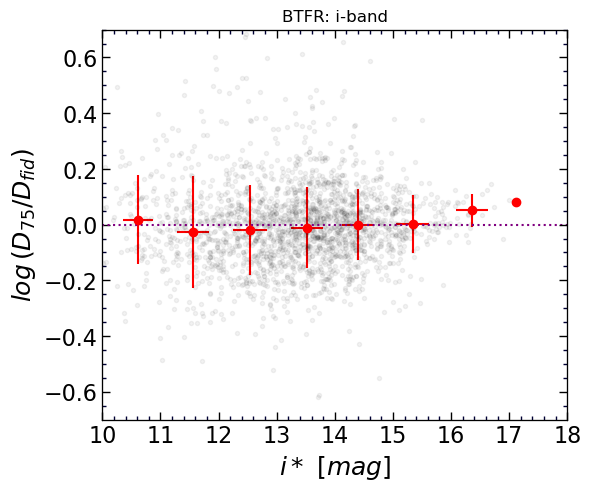

In [7]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['i***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-0.7,0.7))



(<AxesSubplot:label='318a1745-9771-427f-8aac-17e83bb1e1d7'>,
 <AxesSubplot:label='8c31ec43-be19-4623-9128-75dd733642da'>)

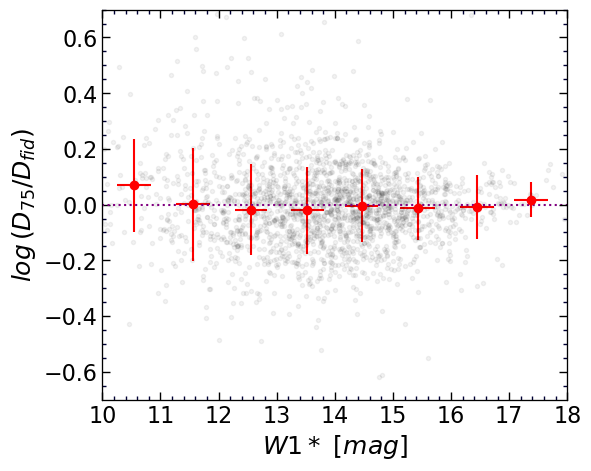

In [11]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff['w1***'].values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-0.7,0.7))



(<AxesSubplot:label='4fe3dea8-5b0c-4376-8f3b-d0912b7d47fb'>,
 <AxesSubplot:label='352a32e6-5ca6-40c5-9687-8c67749cc7bf'>)

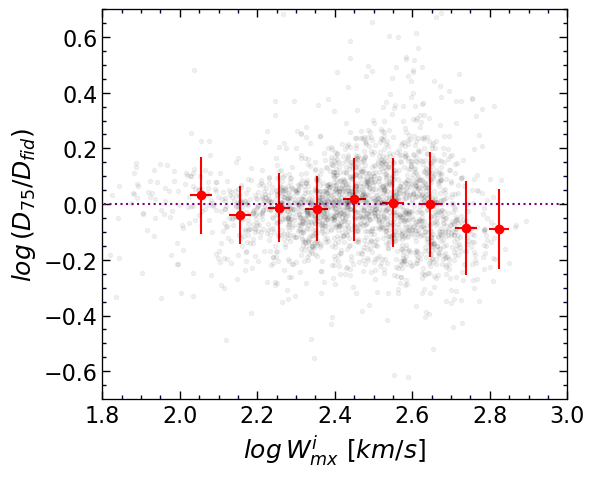

In [18]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.lgWmxi.values
Y = dff.DMi_fid.values-dff.DM1_fid.values

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18)
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([-10,10], [0,0], ':', color='purple')

set_axes(ax, (1.8,3), (-0.7,0.7))

In [8]:
dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values

dff[(dff.Vmod<2500)&(dff.delta<0.1)]

<ipython-input-8-ffef637fabca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["delta"] = dff.DMi_fid.values-dff.DM1_fid.values


,Vmod,DM_75,F21,eF21,lgWmxi,elgWi,DMi_fid,DM1_fid,Qs,Qw,w1***,i***,delta
PGC,,,,,,,,,,,,,
279,1970.0,32.097025,14.455,0.13,2.612,0.005,32.376343,32.281884,5.0,5.0,10.76,10.66,0.094459
889,502.0,29.128212,13.950,0.06,1.963,0.009,29.627324,29.570280,4.0,4.0,15.25,13.85,0.057045
924,1345.0,31.268305,3.665,0.08,2.187,0.011,31.770998,32.000411,5.0,5.0,14.37,13.47,-0.229412
1525,495.0,29.097720,44.485,0.10,2.301,0.004,30.710216,30.827373,5.0,4.0,12.86,11.85,-0.117157
1750,993.0,30.609440,6.870,0.06,2.035,0.025,30.700031,30.707258,5.0,5.0,14.95,14.08,-0.007227
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365234,2149.0,32.285876,2.420,0.07,2.070,0.008,32.638721,32.600588,5.0,3.0,17.35,16.30,0.038133
1419134,2403.0,32.528463,0.620,0.05,1.824,0.134,31.628119,31.593908,5.0,3.0,17.38,16.29,0.034211
4017882,1989.0,32.117868,0.855,0.08,1.843,0.120,31.709618,31.646034,4.0,3.0,17.75,16.74,0.063584


/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Dist,Nd,DM,eDM,C,T,L,M,S,N,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
PGC,,,,,,,,,,,,,,,,,,,,,
4,50.58,1,33.52,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4005,4048,25.0,0.0,9.747,0,0,0,0,0
27,150.66,1,35.89,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,10959,11275,NaN,0.0,0.000,0,0,0,0,0
40,116.95,1,35.34,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,6919,7045,0.0,0.0,3.960,0,0,0,0,0
51,240.99,1,36.91,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,14743,15315,132.0,0.0,253.333,0,0,0,0,0
55,73.79,1,34.34,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4454,4507,NaN,0.0,0.000,0,0,0,0,0


<ipython-input-24-c2e869075a20>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qs>2)]


(<AxesSubplot:label='1559d0b8-b187-4cd4-9844-114293204ffe'>,
 <AxesSubplot:label='7b80bbe0-f029-42ad-bb94-3603db1f7462'>)

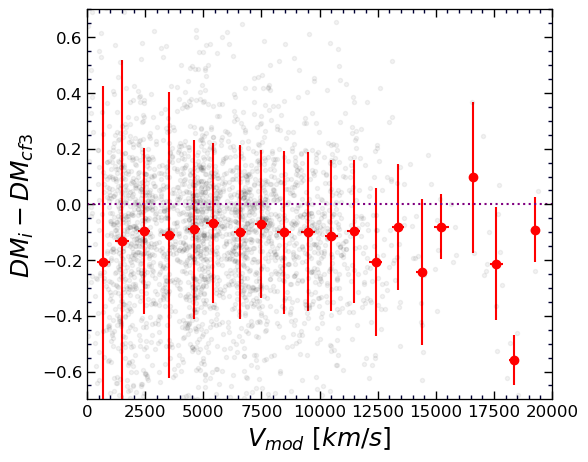

In [24]:
dff = df34[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DMi_fid.values-dff.DM_cf3.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{i}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")


<ipython-input-25-596cc0b3f535>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff = df34[(df.Qw>2)]


(<AxesSubplot:label='9b27a008-6ba8-475d-802d-5da5fdd1866d'>,
 <AxesSubplot:label='dd2ed8e4-e789-42c2-a986-f213da9510fa'>)

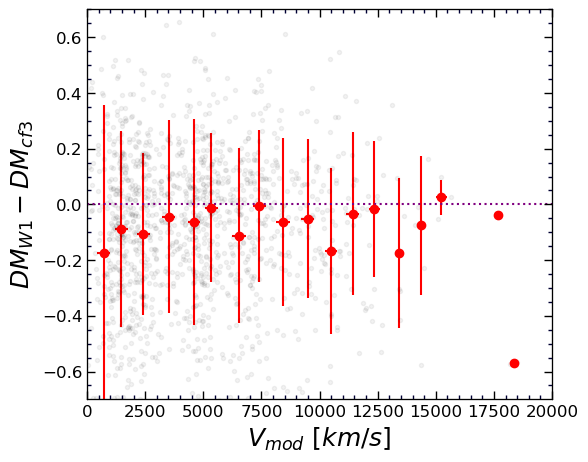

In [25]:
dff = df34[(df.Qw>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.DM1_fid.values-dff.DM_cf3.values
# Y = (dff.DM_75.values-dff.DMi_fid.values)/5.


ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-0.7,0.7), fontsize=12)

# ax.set_title("BTFR: W1-band")
